In [164]:
import matplotlib.pyplot as plt
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

from matplotlib.pyplot import rcParams

import xarray as xr
import numpy as np
import scipy as sp

In [37]:
def init_fonts(fontsize=12):
    rcParams.update({'font.family': 'serif'})
    rcParams.update({'font.serif': 'Liberation Serif'})
    rcParams.update({'mathtext.fontset': 'dejavuserif'})
    rcParams.update({'font.size': fontsize})

In [38]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

df = pd.read_fwf(get_test_data('may4_sounding.txt', as_file_obj=False),
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all'
               ).reset_index(drop=True)

In [172]:
ACCESS_G_soundings = xr.open_dataset('ACCESS_G_soundings.nc')

ACCESS_G_soundings = ACCESS_G_soundings.where(
    ACCESS_G_soundings['pope_regime'] == 2)
ACCESS_G_soundings = ACCESS_G_soundings.mean(dim=['hour', 'time'])
# ACCESS_G_soundings = ACCESS_G_soundings.sel(hour=18).mean(dim=['time'])

In [173]:
p = ACCESS_G_soundings['p'].values * units.Pa
T = (ACCESS_G_soundings['t'].values-273.15) * units.degC
q = ACCESS_G_soundings['q']
u = ACCESS_G_soundings['u'] * units.meter_per_second
v = ACCESS_G_soundings['v'] * units.meter_per_second
heights = ACCESS_G_soundings['altitude'] * units.meter

Td = mpcalc.dewpoint_from_specific_humidity(p, T, q)

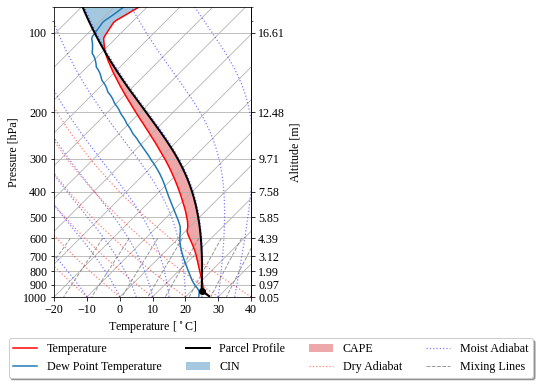

In [174]:
fig = plt.figure(figsize=(12, 6))
# add_metpy_logo(fig, 115, 100)
skew = SkewT(fig=fig, subplot=(1, 3, 1), rotation=45)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# colors = [colors[i] for i in [0, 1, 2, 4, 5, 6]]

init_fonts()

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(p, T, 'r', label='Temperature')
skew.plot(p, Td, colors[0], label='Dew Point Temperature')
# skew.plot_barbs(p[::3], u[::3], v[::3])
skew.ax.set_ylim(1000, 80)
skew.ax.set_xlim(-20, 40)

f = sp.interpolate.interp1d(p[::-1], heights[::-1], fill_value='extrapolate')

secax = skew.ax.secondary_yaxis(location=1)
secax.set_yticks(np.arange(1000, 0, -100))

labels = f(np.arange(100000, 0, -10000))/1000
labels = ['{:.02f}'.format(l) for l in labels]

secax.set_yticklabels(labels)
secax.set_ylabel('Altitude [m]')
skew.ax.set_ylabel('Pressure [hPa]')

skew.ax.set_xlabel(r'Temperature [$^\circ$C]')
skew.ax.set_ylabel(r'Pressure [hPa]')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='Parcel Profile')

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, label='CIN')
skew.shade_cape(p, T, prof, label='CAPE')

# Add the relevant special lines
skew.plot_dry_adiabats(
    label='Dry Adiabat', linewidth=1.25, linestyle='dotted')
skew.plot_moist_adiabats(
    linewidth=1.25, label='Moist Adiabat', linestyle='dotted')
skew.plot_mixing_lines(
    linewidth=1, label='Mixing Lines', linestyle='dashed', colors='grey')

skew.ax.legend(
    loc='lower center', bbox_to_anchor=(1.1, -0.3),
    ncol=4, fancybox=True, shadow=True)

# Show the plot
plt.show()